# 5 Train a classifier on the STL-10 dataset
In this notebook, we will again implement a classifier in Pytorch, with the difference that this time we will use a CNN instead of an MLP for classification. The dataset we will use is the STL-10 dataset. The STL-10 dataset contains images of airplanes, birds, cats, and more, each with a resolution of $96 \times 96$ pixels. We chose this dataset so that the training would run on lower performance computers, e.g. those without a graphics card.

However, classifiers do not work with the textual description of objects like "Airplane", "Bird", "Car" etc. instead each class is represented with a number. We define this representation first, as this will make things easier for us later. For this we choose the lexicographic sorting of the class names and index according to this order. We store the result in a dictionary (a list would also be sufficient).

## 1. Read the Data

In [1]:
import os
import numpy as np
import random
import glob

import torch
import torchvision
from torch.utils.data import Dataset

# from PIL import Image
import cv2

from tqdm import tqdm   # Progress-Bar

# Setze einen Seed für die Reproduzierbarkeit.
torch.manual_seed(1)

class_map_idx_to_str = {0: 'airplane',
                        1: 'bird', 
                        2: 'car', 
                        3: 'cat', 
                        4: 'deer', 
                        5: 'dog', 
                        6: 'horse', 
                        7: 'monkey', 
                        8: 'ship', 
                        9: 'truck'}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1)

# Definiere den Pfad zu den Ordnern train, val und test.
root_dir = os.getcwd() + os.sep + "STL-10_Dataset\\"

# Definiere den Pfad zu den trainierten Gewichten.
checkpoint_dir = os.getcwd() + os.sep + "Checkpoints" + os.sep

checkpoint_path = os.getcwd() + "/Checkpoints/checkpoint.pth.tar"

# Erstelle einen neuen Ordner Checkpoints im aktuellen Verzeichnis.
if not os.path.isdir(os.getcwd() + "/Checkpoints/"):
    os.makedirs(os.getcwd() + "/Checkpoints/")

# Lade den aktuellen Checkpoint (falls vorhanden), ansonsten erstelle einen neuen.
def create_or_load_checkpoint(model, epoch=-1, optimizer=None, last_loss=10**20):
    if os.path.isfile(checkpoint_path):
        print("=> Looking for checkpoint")
        try:
            checkpoint = torch.load(checkpoint_path)
            epoch = checkpoint['epoch']
            print("Loaded epoch number is", epoch)            
            last_loss = checkpoint['best_loss']
            print("Loaded best loss is", last_loss)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            if not optimizer is None:
                optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> Found and loaded checkpoint")
        except:
            print("Your checkpoint does not contain trained weights. Your old weights will be overwritten.")
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
    else:
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
        print("=> No checkpoint found. You have to train first.")
    return epoch, last_loss

## 2. Bilder laden und Exkurs zu Augmentierungen (ToDo + Bonusaufgabe)
Im folgenden Abschnitt laden wir die Bilder. Wenn Sie die Bonusaufgabe machen möchten, sollen die Bilder nicht mehr nur im originalen Zustand dem Training übergeben werden, sondern die Bilder sollen zovor augmentiert werden. Das heißt, die Bilder sollen mit einer Wahrscheinlichkeit von:
 * 75% rotiert werden. Die Rotation soll im Bereich -15 bis +15 Grad liegen. (2 Punkte)
 * 50% an der vertikalen Achse gespiegelt werden. (1 Punkt)

Weitere gängige Augmentierungsmethoden, die Sie freiwillig implementieren können, sind z.B.
1. Änderung in Helligkeit, Sättigung und Farbwert: verwende HSV statt RGB und ändere H (Hue), S (Saturation) und V (Value)
2. Verschiebung: Bild wird etwas nach oben, unten, links oder rechts verschoben.
3. Skalierung: Bild wird vergrößert oder verkleinert
4. Scherung: Bild wird geschert: Eine Seite bleibt fest, die gegenüberliegende Seite wird verschoben
5. Crops: Statt dem gesamten Bild werden dem Modell nur Teile des Bildes gezeigt (meist zufällige Bildausschnitte und mehrere)
6. Rauschen: Auf das Bild wird ein verrauschtes Array addiert

Die Idee der Augmentierung ist, dass man künstlich die Anzahl der Eingabebilder vergrößert. Mittlerweile ist man so weit, dass man neuronale Netze verwendet, sogenannte GANs (Generative Adversarial Network), die für einen gegebenen Datensatz, die Verteilung dieses Datensatzes lernen. Dadurch lassen sich ähnliche, täuschend echte Bilder erzeugen, die wiederum für ein anderes Netz verwendet werden können. Diese Technik verwendet man häufig bei Daten für die es sehr schwer ist gelabelte Daten zu bekommen, z.B. Sensordaten für Aktivitätserkennung.

In [2]:
class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        self.root_dir = root_dir
        self.loader_mode = loader_mode
        # ToDo

    def __len__(self):
        # ToDo

    def __getitem__(self, idx):
        # ToDo



## 2. Dataset zu Dataloader (nothing ToDo)
Wir übergeben das Dataset dem Dataloader.

In [3]:
batch_size_train = 8 # 88
batch_size_val = 1

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)

dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset.imgs_and_lbls)
dataset_sizes["val"] = len(val_dataset.imgs_and_lbls)
dataset_sizes["test"] = len(test_dataset.imgs_and_lbls)
dataset_sizes

  7%|███████▍                                                                                                       | 284/4250 [00:00<00:01, 2839.37it/s]

Cache Data:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2731.59it/s]


{'train': 4250, 'val': 250, 'test': 500}

## 3. Plotten von Zwischenergebnissen (nothing ToDo)
Später, während des Trainings und der Validierung, möchten wir gerne einige Zwischenergebnisse sehen. Hierfür verwenden wir die nachfolgende Methode. Dabei wird in Ihrem Verzeichnis ein Ordner mit dem Namen *Some Results [YYYY-MM-DD HH_MM_SS]* (Zeitstempel kommt von oben) angelegt. Darin finden Sie nach ausreichend langem Training, zwei Unterordner *train* und *val*. Beide Unterordner enthalten die Zwischenergebnisse. Die Dateinamen sehen wie folgt aus:
  
<br>
<center>Epoch_e;cls_i.png</center>

und bedeuten, dass das gezeigte Bild in der Epoche e, Iteration i, als Klasse cls klassifiziert wurde.
<br>  
<br>  
<br>  

### 3.1 Pytorch Tensoren und ihre Dimensionsreihenfolge (nothing ToDo)
Ein Pytorch Tensor hat in der Regel folgende shape:

<br>
<center>[batch_size, num_channels, height, width]</center>

Das heißt, um ein RGB Bild zu plotten müssen wir uns erst einmal für einen Batchindex entscheiden. Um unnötigen Ärger mit nichtvorhandenen Indizes zu vermeiden, wählen wir im nächsten Abschnitt *batch_idx = 0*, somit bekommen wir auch keinen Fehler, selbst wenn wir mit einer Minibatch von *batch_size = 1* trainieren. Folglich ist *inp* von der Form:

<br>
<center>[num_channels, height, width]</center>

Ein weiterer Unterschied bezüglich der Dimensionsreihenfolge zwischen der Pytorch Tensoren und numpy Arrays ist, dass bei numpy Arrays die Channels am Ende stehen. Um diese Reihenfolge anzupassen, verwenden wir im folgenden:

<br>
<center>inp.transpose((1, 2, 0))</center>

Das heißt die erste Dimension wird an die nullte Dimension, die zeite Dimension an die erste Dimension und die nullte an die zweite Dimension verschoben. Oft spricht man auch von *channel first* oder *channel last*.

<br>
Da die Pytorch Tensoren Float-Tensoren sind, enthalten die Channels Werte zwischen 0 und 1. Wenn wir aber mit PIL (Pillow) ein Bild speichern möchten, müssen wir den Tensor zu einem uint8 Format casten (Restklassenring Z/256Z) und sicherstellen, dass die Werte zwischen 0 und 255 liegen.

In [4]:
def plot_some_results(inputs, preds, class_map, img_counter, epoch, phase):
    batch_idx = 0
    
    # Den Teil ".cpu().detach()" brauchen wir hier nicht unbedingt, da wir nicht auf einer Grafikkarte arbeiten.
    # Könnte aber für alle interessant sein, die das Zuhause auf ihrem eigenen PC mit GPU Unterstüzung laufen lassen.
    inp = np.array(inputs.cpu().detach().numpy()[batch_idx], dtype=np.float32)
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    # Da die Bilder zuvor normalisiert wurden, müssen wir dies erst rückgängig machen.
    for channel in range(3):
        inp[channel] = inp[channel] * stds[channel] + means[channel]
        inp[channel] = np.minimum(np.maximum(inp[channel], 0), 1)    
    
    inp = np.array(inp.transpose((1, 2, 0)) * 255.0, dtype=np.uint8)
    class_name = class_map[int(preds[batch_idx])]

    save_dir_results = os.getcwd() + os.sep + "Results" + os.sep + phase + os.sep

    if not os.path.isdir(save_dir_results):
        os.makedirs(save_dir_results)
    
    save_path = save_dir_results + "Epoch_" + str(epoch) + ";" + class_name + "_" + str(img_counter) + ".png"
    cv2.imwrite(save_path, inp)
    img_counter += 1

## 4. Convolutional Neural Network definieren (ToDo)
Im folgenden betrachten wir drei Modelle

0. Small_Model
1. Our_First_CNN
2. ResNet34

Das *Small_Model* soll Ihnen Hilfestellung geben, wie ein CNN implementiert werden kann. Dabei wurden einige aus der Vorlesung bekannte Konzepte wie z.B. die Convolution Operation (```nn.Conv2d```), Dropout (```nn.Dropout```), Fully-Connected-Layer (```nn.Linear```), Pooling-Layer (z.B. Max-Pooling ```nn.MaxPool2d```) und eine Aktivierungsfunktion (z.B. ```nn.ReLU```) verwendet.

Das *ResNet34* ist ein vordefiniertes CNN mit dem oft erstaunlich gute Ergebnisser erzielt werden können. Es soll als Vergleichsmodell dienen.

Außerdem gibt es noch das *Our_First_CNN*. Sie können diese Klasse als Vorlage verwenden um ihr eigenes CNN zu implementieren. 

<br>  
Bei vordefinierten Modellen wie z.B. AlexNet, ResNet oder GoogleNet können wir vortrainierte Gewichte verwenden. Das tolle an vortrainierten Modellen bzw. Gewichten ist, dass es keine große Rolle spielt ob sie zuvor ähnliche Objekte gesehen haben. Wir könnten z.B. ein Modell auf verschiedene Hundearten vortrainieren und später verwenden um das gleiche Modell zu verwenden um Schiffe von Autos zu unterscheiden. Diese Technik nennt sich Transfer-Learning. Der Grund, weshalb das funktioniert liegt daran, dass tiefe Netze viele verschiedene Arten von Features lernen. Diese Feature können wenig komplex sein z.B. Linien und Kurven (häufig in den ersten Layern) bis hin zu sehr komplexen Features wie z.B. die Schnautze eines Labradors oder die Ohren eines Luchses (oft in den letzten Layern).

Wenn Sie also ein anderes vordefiniertes Modell ausprobieren möchten sollten Sie den Parameter `pretrained` auf `True` setzen. Die Datensätze auf denen zuvor trainiert wurde, haben meist nicht die gleiche Anzahl an Klassen, wie wir sie benötigen. Daher schneiden wir den letzten Layer ab und setzen einen neuen Layer mit der von uns benötigten Anzahl an Klassen bzw Neuronen dran. Der letzte Layer ist bei Klassifizierern in der Regel ein Fully-Connected Layer. Die neu zugewiesene Gewichte kennen wir natürlich nicht und wählen daher eine zufällige Belegung.

### ToDo
Ihre Aufgabe ist es also die Klasse *Our_First_CNN* so zu implementieren, dass ein Modell entsteht das besser ist als das *Small_Model*.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

which_model = 2

class Small_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), bias=False)
        self.dropout = nn.Dropout(0.33)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 46 * 46, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.dropout(self.conv1(x))))
        x = torch.flatten(x, 1) # flatte alle Dimensionen außer der Batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
class Our_First_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(1, 1), padding=(0, 0))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), bias=False)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)


        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 19 * 19, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # print("x.size (1) =", x.shape)
        x = torch.relu(self.conv1(x))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = self.pool4(torch.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatte alle Dimensionen außer der Batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
def resnet34(pretrained, num_classes=1000):
    # Lade das ResNet34
    model = torchvision.models.resnet34(pretrained=pretrained)
    
    # Die Anzahl der eingehenden Neuronen in den letzten Layer des ResNet34 werden in der Variable num_features gespeichert.
    num_features = model.fc.in_features
    
    # Ändere die Anzahl ausgehender Neuronen im letzten Layer des ResNet34, indem ein neuer Fully-Connected Layer 
    # zugewiesen wird.
    model.fc = torch.nn.Linear(num_features, num_classes)
    return model

## 5. Implementieren der Trainingsmethode (ToDo)
Im folgenden sollen Sie die Trainingsmethode implementieren. 
Hinweis: Sie können im Prinzip die Trainingsmethode aus dem letzen Übungsblatt verwenden und Kleinigkeiten anpassen, wie z.B. das verwendete Modell. Auch folgenden Tutorials könnten hilfreich sein:
1. [Ein Tutorial über Transferlearning, am Beispiel von Bienen und Ameisen](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model)
2. [Training eines Klassifizierers, am Beispiel von Cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network)

In [6]:
import torch.optim as optim
from torch.optim import lr_scheduler
import sys

# Wenn Sie eine NVIDIA Grafikkarte besitzen und CUDA installiert ist, können Sie diesen Wert zu "cuda" ändern.
# device = "cpu"
device = "cuda"


def train_model(num_epochs=100):

    if which_model == 0:
        model = Small_Model()
    elif which_model == 1:
        model = Our_First_CNN()
    else:
        model = resnet34(pretrained=True, num_classes=len(class_map_idx_to_str))
        
    model = model.to(device)


    # ToDo




## 6. Evaluieren des trainierten Modells (ToDo)
Vervollständigen Sie die Methode test_classifier() so, dass eine Confusion Matrix für alle Testbilder berechnet und visualsiert wird. In *all_imgs* sind alle Pfade zu den Testbildern zu finden.  
<br>

In [15]:
import matplotlib.pyplot as plt

def test_model(test_dataloader):
    
    # ToDo

## 7. Training und Valdierung starten (ToDo)
Starten Sie nun das Training.

In [8]:
# ToDo

checkpoint_path = D:\Dropbox\DFKI (Arbeit)\Vorlesungen\Kuenstliche Intelligenz\2022_2023\Exercise Sheets_22_23\5. Exercise Sheet\Notebooks/Checkpoints/checkpoint.pth.tar
=> No checkpoint found. You have to train first.
Current learning rate: 0.01
Epoch 0/10
-------------------------
Iteration 531 of 532 Loss: 4.1828
train Loss: 1.0482
Iteration 249 of 250 Loss: 0.8352
val Loss: 0.8359
	--------- ********************************* ---------
	--------- *** New best Validation score *** ---------
	--------- ********************************* ---------
Saving model weights. Do not interrupt the saving-process ... done.

Current learning rate: 0.009000000000000001
Epoch 1/10
-------------------------
Iteration 531 of 532 Loss: 2.0989
train Loss: 0.5257
Iteration 249 of 250 Loss: 0.4686
val Loss: 0.4686
	--------- ********************************* ---------
	--------- *** New best Validation score *** ---------
	--------- ********************************* ---------
Saving model weights. Do not

Testen Sie Ihr Model.

In [ ]:
# ToDo

## 8. Metriken berechnen (ToDo)
Berechnen Sie die Precision, Recall und $F_1$-Score und visualisieren Sie die Confusion Matrix.

In [18]:
# ToDo

## 9. Ergebnisse visualisieren
Visualisieren Sie Ihre Ergebnisse in einer Confusion Matrix.

TP_cls_i = 43.0
FP_cls_i = 3.0
FN_cls_i = 7.0
Recall_i = 0.86
Precision_i = 0.9347826086956522
F1_i = 0.8958333333333334
TP_cls_i = 44.0
FP_cls_i = 3.0
FN_cls_i = 6.0
Recall_i = 0.88
Precision_i = 0.9361702127659575
F1_i = 0.9072164948453608
TP_cls_i = 45.0
FP_cls_i = 1.0
FN_cls_i = 5.0
Recall_i = 0.9
Precision_i = 0.9782608695652174
F1_i = 0.9375
TP_cls_i = 30.0
FP_cls_i = 11.0
FN_cls_i = 20.0
Recall_i = 0.6
Precision_i = 0.7317073170731707
F1_i = 0.6593406593406594
TP_cls_i = 40.0
FP_cls_i = 7.0
FN_cls_i = 10.0
Recall_i = 0.8
Precision_i = 0.851063829787234
F1_i = 0.8247422680412372
TP_cls_i = 31.0
FP_cls_i = 14.0
FN_cls_i = 19.0
Recall_i = 0.62
Precision_i = 0.6888888888888889
F1_i = 0.6526315789473685
TP_cls_i = 44.0
FP_cls_i = 15.0
FN_cls_i = 6.0
Recall_i = 0.88
Precision_i = 0.7457627118644068
F1_i = 0.8073394495412843
TP_cls_i = 44.0
FP_cls_i = 15.0
FN_cls_i = 6.0
Recall_i = 0.88
Precision_i = 0.7457627118644068
F1_i = 0.8073394495412843
TP_cls_i = 50.0
FP_cls_i = 4.0
FN_cls_i =

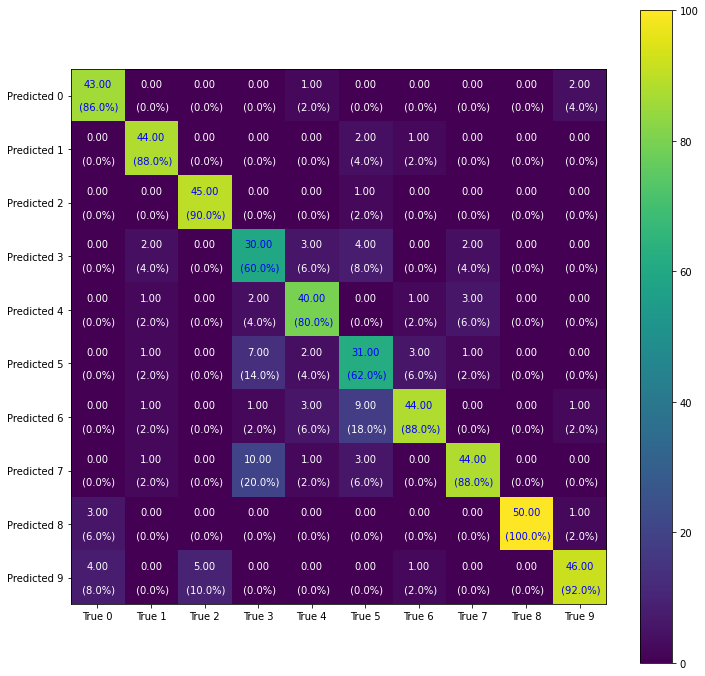

In [19]:
# ToDo